In [1]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import geopandas as gpd
%matplotlib inline

from shapely.geometry import mapping
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import urbanFormPy as up

In [2]:
#initialise path, names, etc.
# use complete extension of the city to extract regions!

city_name = 'London'
place = 'London, UK'
epsg = 27700

crs = {'init': 'epsg:27700', 'no_defs': True}

### Downloading

Choose between the following methods:
* *OSMplace*, provide an OSM place name (e.g. City).
* *OSMpolygon*, provide an OSM polygon (relation) name.
* *distance_from_address*, provide a precise address and define parameter "distance" (which is otherwise not necessary)

In [19]:
download_method = 'distance_from_address'
distance = 10000
nodes_graph, edges_graph = up.get_network_fromOSM(download_method, place, 'walk', epsg, distance = distance)

In [20]:
"""
- "same_uv_edges" regulates the handling of edges with same pair of u-v nodes but different geometries.
When true keeps a center line between the two segments, unless one of the two segments is significantly longer than 
the other (>30%). In this case, the longer segment is deleted.
"""
nodes_graph, edges_graph = up.clean_network(nodes_graph, edges_graph, dead_ends = True, remove_disconnected_islands = True,
                            self_loops = True, same_uv_edges = True)

Done after  7  cleaning cycles


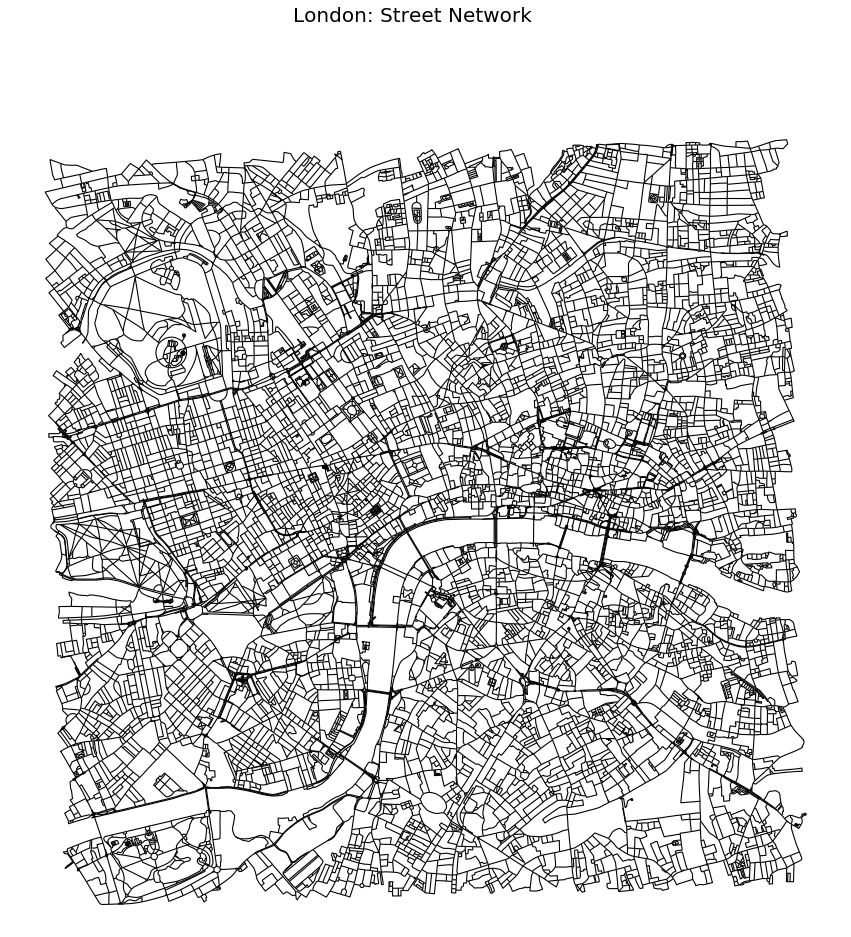

In [8]:
up.plot_lines(edges_graph, scheme = None,
              black_background = False, fig_size = 15, title = city_name+': Street Network')

In [ ]:
# saving
saving_path = 'C:/Users/g_filo01/sciebo/Scripts/Image of the City/Outputs/'+city_name+'/large_network/for_Simulation/'
nodes_graph.to_file(saving_path+city_name+'_nodes.shp')
edges_graph.to_file(saving_path+city_name+'_edges.shp')

### Loading from local path

In [4]:
loading_path = 'C:/Users/g_filo01/sciebo/Scripts/Image of the City/Outputs/'+city_name+'/large_network/for_Simulation/'
nodes_graph = gpd.read_file(loading_path+city_name+'_nodes.shp')
edges_graph = gpd.read_file(loading_path+city_name+'_edges.shp')
nodesDual_graph = gpd.read_file(loading_path+city_name+'_nodesDual.shp')
edgesDual_graph = gpd.read_file(loading_path+city_name+'_edgesDual.shp')

nodes_graph.index = nodes_graph.nodeID
edges_graph.index = edges_graph.edgeID
nodes_graph.index.name = None
edges_graph.index.name = None

## Barriers identification

Choose between the following methods:
* *OSMplace*, provide an OSM place name (e.g. City).
* *distance_from_address*, provide a precise address and define parameter "distance" (which is otherwise not necessary)

In [5]:
from shapely.geometry import Point
download_method = 'OSMplace'
place = 'Greater London, United Kingdom'
envelope = edges_graph.unary_union.envelope
coords = mapping(envelope)["coordinates"][0]
d = [(Point(coords[0])).distance(Point(coords[1])), (Point(coords[1])).distance(Point(coords[2]))]
distance = max(d)

In [34]:
road_barriers = up.road_barriers(place, download_method, distance, crs)
waterway_barriers = up.waterway_barriers(place, download_method, distance, crs)
railway_barriers = up.railway_barriers(place,download_method, distance, crs)
park_barriers = up.park_barriers(place,download_method, distance, crs, min_area = 20000)

In [35]:
barriers = road_barriers.append(waterway_barriers)
barriers = railway_barriers.append(barriers)
barriers = park_barriers.append(barriers)
barriers.reset_index(inplace = True, drop = True)
barriers['barrierID'] = barriers.index.astype(int)

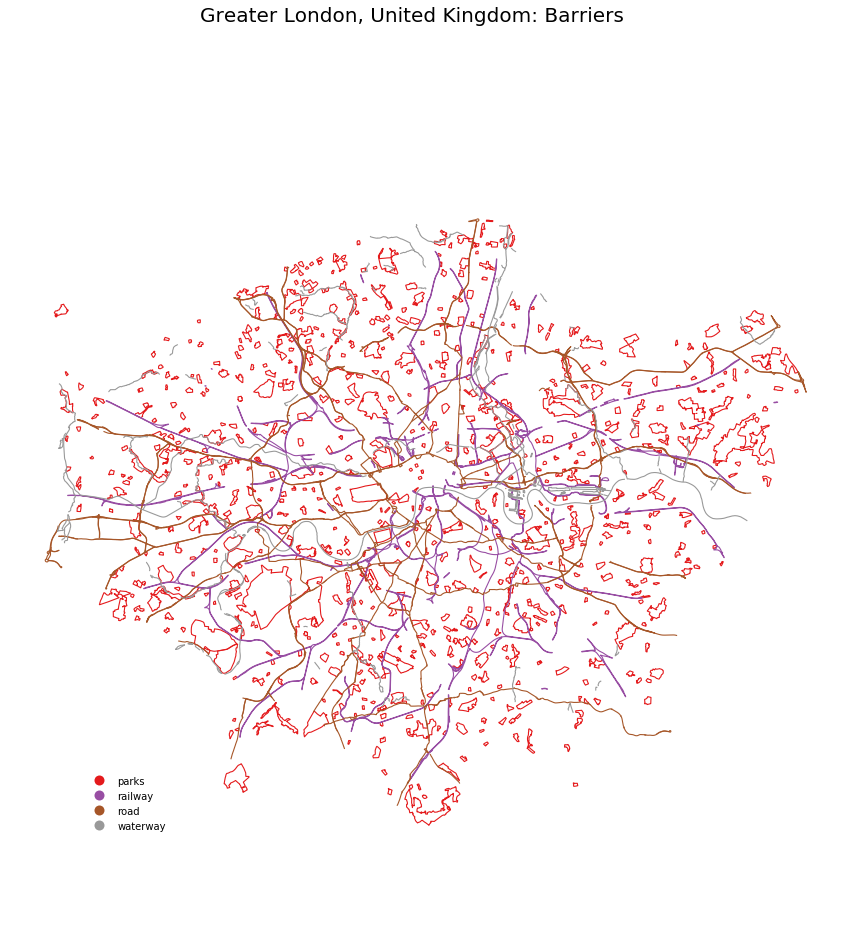

In [36]:
up.plot_lines(barriers, cmap = 'Set1', column = 'type',
              black_background = False, fig_size = 15, title = place+': Barriers', legend = True)

In [37]:
# saving as entire network
saving_path = 'C:/Users/g_filo01/sciebo/Scripts/Image of the City/Outputs/'+city_name+'/entire_network/'
barriers.to_file(saving_path+city_name+"_barriers.shp", driver='ESRI Shapefile')

In [38]:
sindex = edges_graph.sindex
barriers_within = barriers[barriers.intersects(envelope)]
tmp = barriers_within[barriers_within['type'].isin(['waterway', 'park'])]
edges_graph['p_barr'] = edges_graph.apply(lambda row: up.positive_barriers_along(row['edgeID'], tmp, edges_graph, 
                                                    sindex, offset = 200), axis = 1)
tmp = barriers_within[barriers_within['type'].isin(['railway', 'road'])]
edges_graph['n_barr'] = edges_graph.apply(lambda row: up.crossing_barriers(row['geometry'], tmp), axis = 1)

# crossing any kind of barrier?
edges_graph['c_barr'] = edges_graph.apply(lambda row: up.crossing_barriers(row['geometry'], barriers_within), axis = 1)
edges_graph['sep_barr'] = edges_graph.apply(lambda row: True if len(row['c_barr']) > 0 else False, axis = 1)

## Visualisation

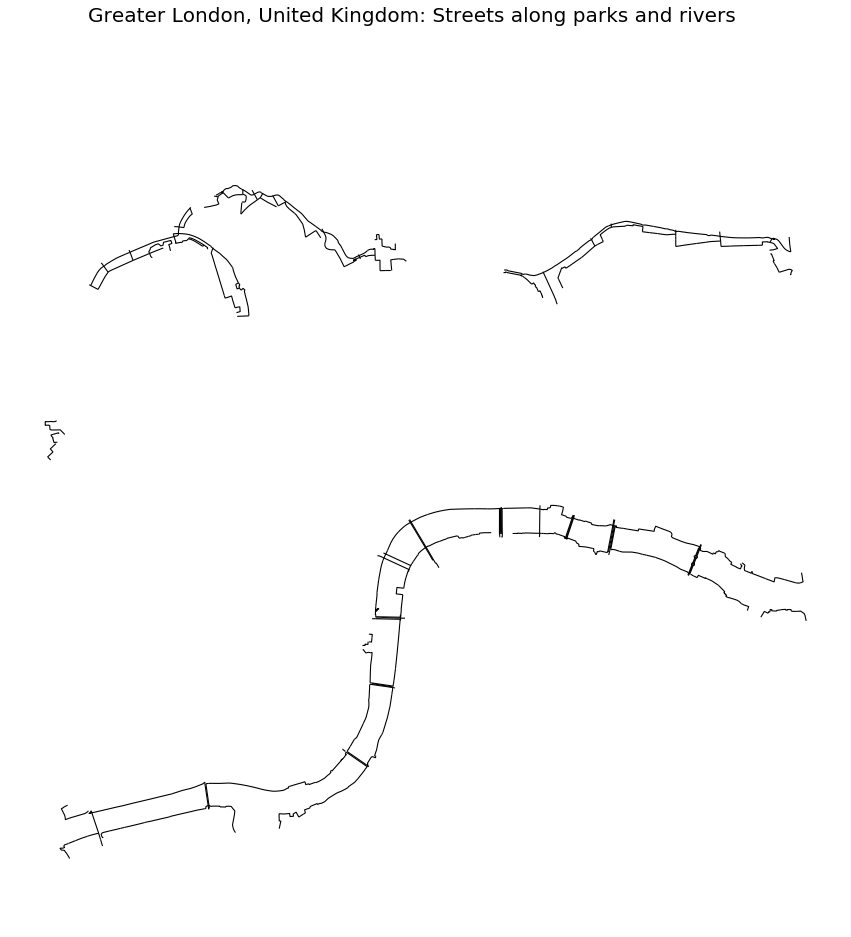

In [39]:
edges_graph['rivers_parks'] = edges_graph.apply(lambda row: True if len(row['p_barr']) > 0 else False, axis = 1)
edges_graph['barriers'] = edges_graph.apply(lambda row: True if len(row['n_barr']) > 0 else False, axis = 1)
tmp = edges_graph[edges_graph.rivers_parks == True].copy()
up.plot_lines(tmp, black_background = False, fig_size = 15, title = place+': Streets along parks and rivers', legend = False)

In [237]:
tmp = edges_graph[edges_graph.barriers == True].copy()
up.plot_lines(tmp, black_background = False, fig_size = 15, title = place+': Streets crossing barriers', legend = False)

In [16]:
# saving
saving_path = 'C:/Users/g_filo01/sciebo/Scripts/Image of the City/Outputs/'+city_name+'/large_network/for_Simulation/'

to_convert = ['p_barr', 'n_barr', 'c_barr']
edges_graph_string = edges_graph.copy()
for column in to_convert: edges_graph_string[column] = edges_graph_string[column].astype(str)
edges_graph_string.to_file(saving_path+city_name+"_edges.shp", driver='ESRI Shapefile')

## District identification full network - Single Membership

In [129]:
from cdlib import algorithms
from networkx.algorithms import community

In [ ]:
## Single Membership

In [131]:
# ## modularity-optimisation
# louvain = algorithms.louvain(dual_graphIG, weight='deg', resolution=1.0, randomize=False)
# # walktrap
# walktrap = algorithms.walktrap(dual_graphIG)
# # Clauset-Newman greedy algortim 
# caluset_newman = algorithms.greedy_modularity(dual_graphIG, weight='deg')
# label propagation

# label_propagation = algorithms.label_propagation(dual_graphIG)

In [180]:
from networkx.algorithms import community



In [182]:
# results = [louvain.communities, walktrap.communities, caluset_newman.communities, label_propagation.communities]
columns = ['louvain', 'walktrap', 'caluset', 'label_propagation']

In [111]:
for column in columns: nodesDual_graphIG[column] = 0

for n, alg in enumerate(results):
    for community, nn in enumerate(alg):
        nodesDual_graphIG.loc[nodesDual_graphIG.index.isin(nn), columns[n]] = community 

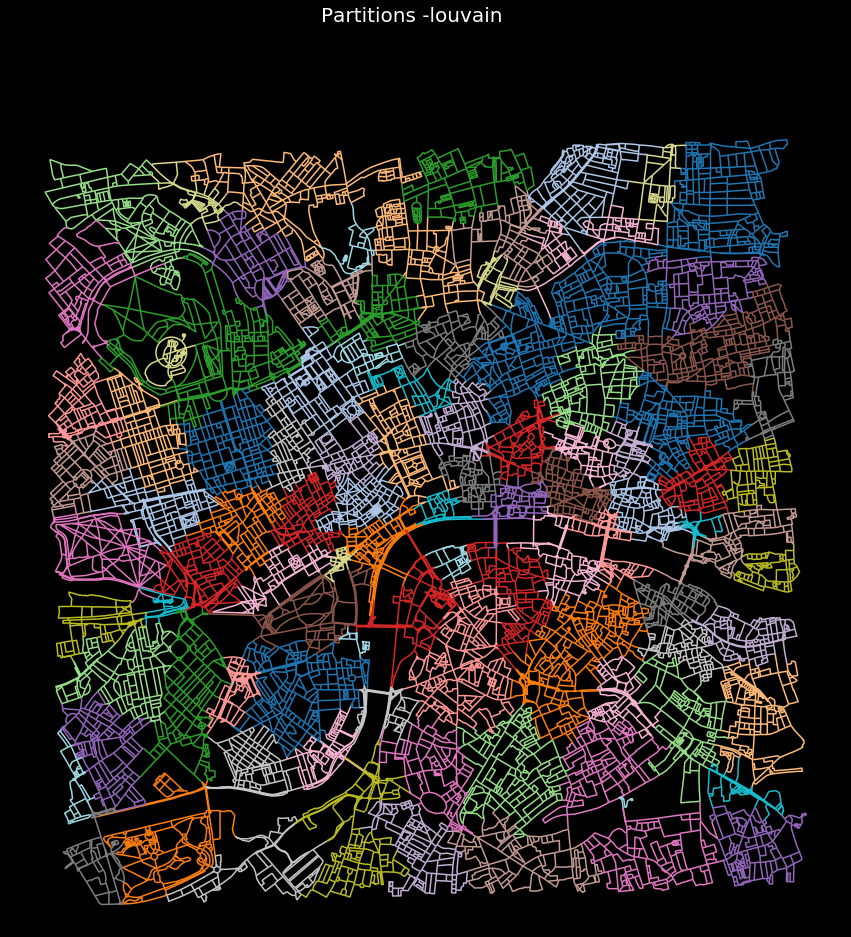

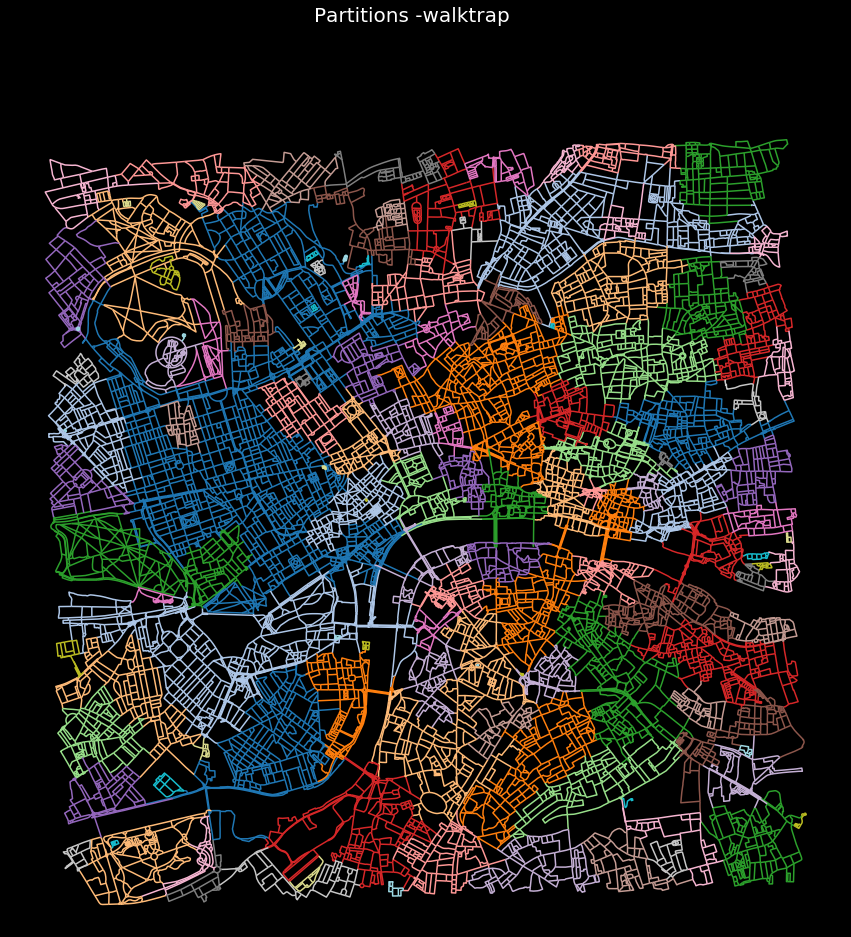

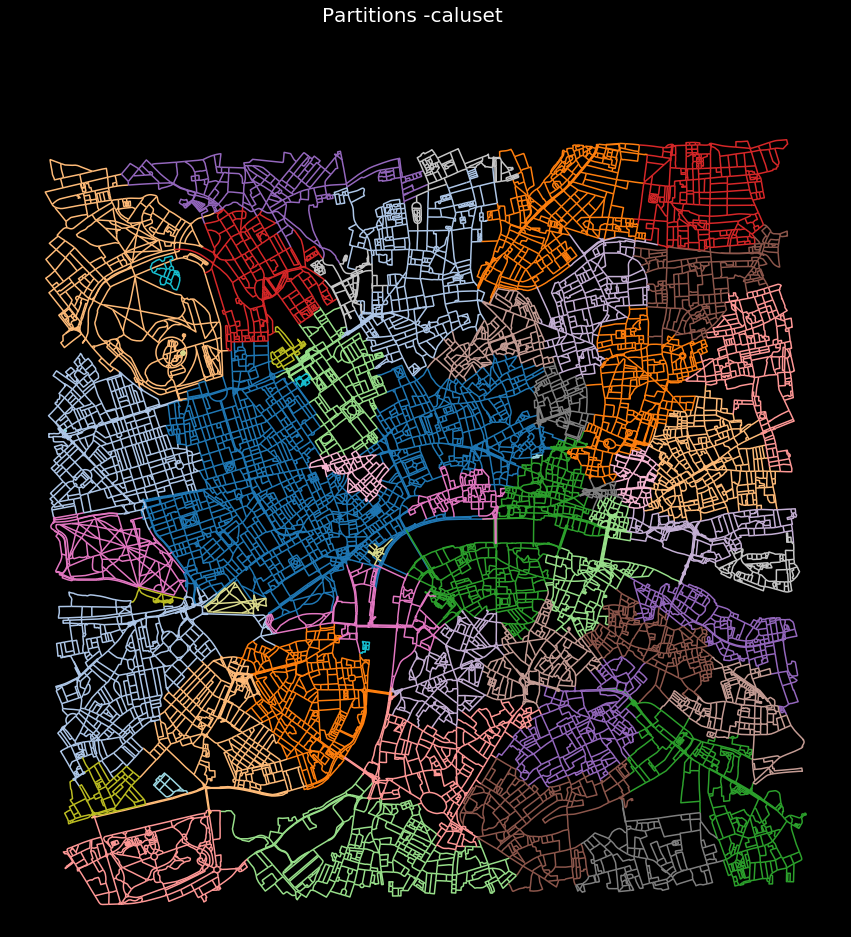

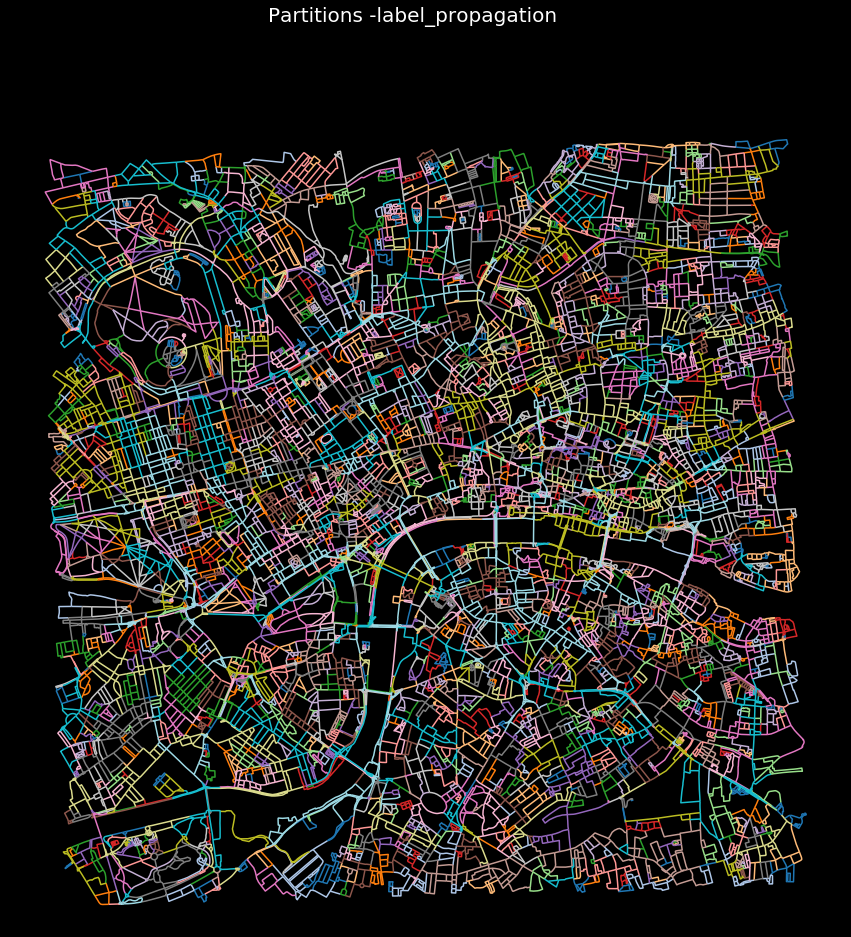

In [184]:
for column in columns:
   
    # visualising
    up.plot_lines(districts, column = column, title = 'Partitions -'+column, lw = 1.5, cmap = 'tab20', black_background = True, 
              legend = False, fig_size = 15)


In [200]:
## polygonise

polygons = []
partitionIDs = []
d = {'geometry' : polygons, 'partitionID' : partitionIDs}

partitions = districts['caluset'].unique()
for i in partitions:
    polygon =  districts[districts['caluset'] == i].geometry.unary_union.convex_hull
    polygons.append(polygon)
    partitionIDs.append(i)
    
df = pd.DataFrame(d)
partitions_caluset = gpd.GeoDataFrame(df, crs=crs, geometry=df['geometry'])

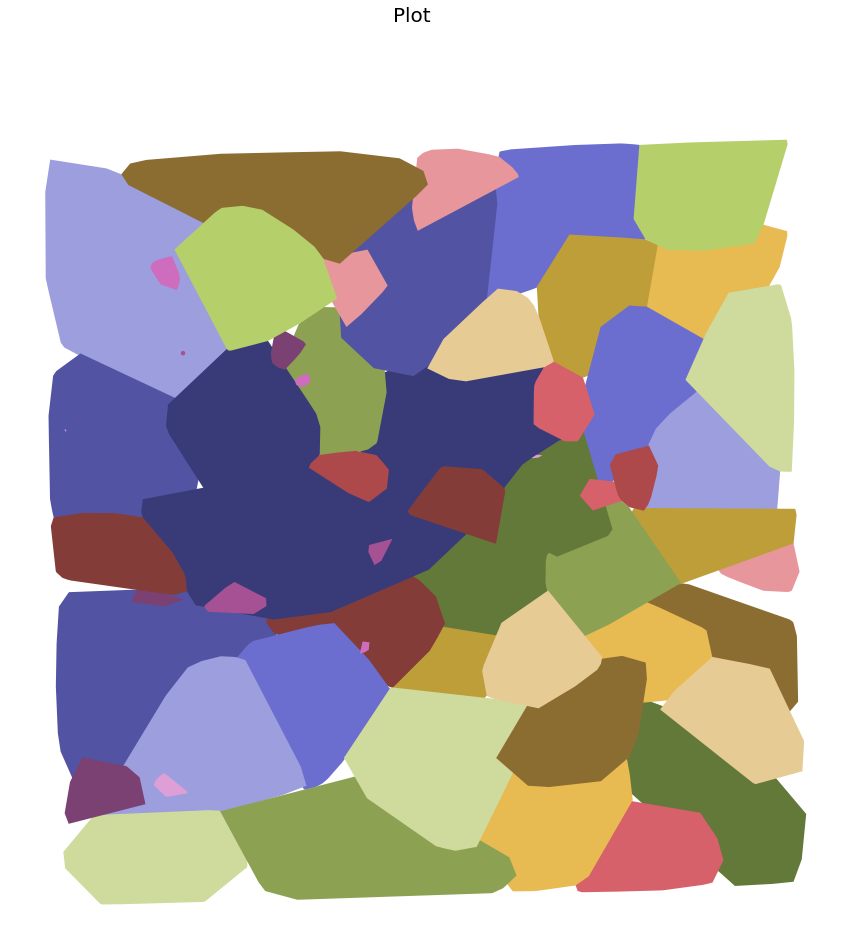

In [201]:
up.plot_polygons(partitions_caluset, column = 'partitionID', cmap = 'tab20', title =  "Plot", legend = False, 
                 black_background = False,  fig_size = 15)

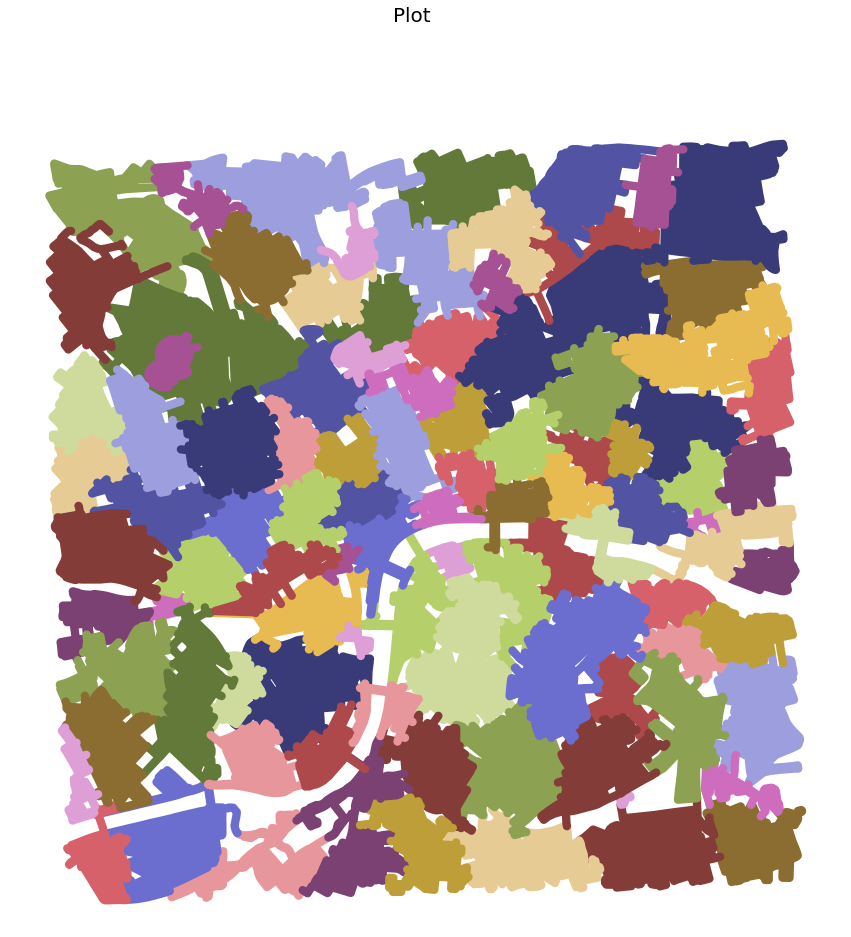

In [74]:
def reset_index_street_network_gdfs(nodes_gdf, edges_gdf, label_index):
    """
    The function simply reset the indexes of the two dataframes.
     
    Parameters
    ----------
    nodes_gdf: Point GeoDataFrame
        nodes (junctions) GeoDataFrame
    edges_gdf: LineString GeoDataFrame
        street segments GeoDataFrame
   
    Returns
    -------
    tuple of GeoDataFrames
    """
    
    nodes_gdf = nodes_gdf.reset_index(drop = True)
    nodes_gdf["igraph_"+label_index] = nodes_gdf.index.values.astype("int64")
    nodes_gdf = nodes_gdf.copy()
    edges_gdf = edges_gdf.copy()
    edges_gdf = edges_gdf.rename(columns = {"u":"old_u", "v":"old_v"})
    edges_gdf = pd.merge(edges_gdf, nodes_gdf[[label_index, "igraph_"+label_index]], how="left", left_on="old_u", right_on=label_index)
    edges_gdf = edges_gdf.rename(columns = {"igraph_"+label_index: "u"})
    edges_gdf = pd.merge(edges_gdf, nodes_gdf[[label_index, "igraph_"+label_index]], how="left", left_on="old_v", right_on=label_index)
    edges_gdf = edges_gdf.rename(columns = {"igraph_"+label_index:"v"})
    
    nodes_gdf.index = nodes_gdf["igraph_"+label_index].astype(int)
    nodes_gdf.index.name = None
    nodes_gdf.drop(["index"], axis = 1, inplace = True, errors = "ignore")
    edges_gdf = edges_gdf.reset_index(drop=True)
   
    return nodes_gdf, edges_gdf

def dual_graph_fromGDF(nodes_dual, edges_dual):

    """
    The function generates a NetworkX graph from dual-nodes and -edges GeoDataFrames.
            
    Parameters
    ----------
    nodes_dual: Point GeoDataFrame
        the GeoDataFrame of the dual nodes, namely the street segments' centroids
    edges_dual: LineString GeoDataFrame
        the GeoDataFrame of the dual edges, namely the links between street segments' centroids 
        
    Returns
    -------
    NetworkX Graph
    """
   
    edges_dual.u = edges_dual.u.astype(int)
    edges_dual.v = edges_dual.v.astype(int)
    
    Dg = nx.Graph()   
    Dg.add_nodes_from(nodes_dual.index)
    attributes = nodes_dual.to_dict()
    
    for attribute_name in nodes_dual.columns:
        # only add this attribute to nodes which have a non-null value for it
        if attribute_name == "intersecting": continue
        attribute_values = {k:v for k, v in attributes[attribute_name].items() if pd.notnull(v)}
        nx.set_node_attributes(Dg, name=attribute_name, values=attribute_values)

    # add the edges and attributes that are not u, v, key (as they're added
    # separately) or null
    for _, row in edges_dual.iterrows():
        attrs = {}
        for label, value in row.iteritems():
            if (label not in ["u", "v"]) and (isinstance(value, list) or pd.notnull(value)):
                attrs[label] = value
        Dg.add_edge(row["u"], row["v"], **attrs)

    return Dg

In [11]:
# CPM
cpm = algorithms.cpm(dual_graph, initial_membership=None, weights='deg', node_sizes=None, resolution_parameter=1)

InternalError: Error at c:\projects\python-igraph\vendor\build\igraph\igraph-0.8.0-msvc\src\type_indexededgelist.c:269: cannot add edges, Invalid vertex id

In [9]:




# # Girvan-Newman greedy algortim 
# girvan_newman = algorithms.girvan_newman(dual_graph, level = 3)







KeyboardInterrupt: 

In [235]:
"""
Different weights are used to extract the partitions. "None" indicates that no weights will be used 
(only topological relationships will matter). The function returns a GeoDataFrame with partitions assigned to edges,
with column named as "p_name_weight" (e.g. "p_length")
 
"""
weights = ['length', 'rad', None]
for i in weights:
    edges_graph = up.identify_regions(dual_graph, edges_graph, weight = i)
    
    # visualising
up.plot_lines(edges_graph, column = "p_no_weight", title = 'Districts', lw = 1.5, cmap = 'tab20', black_background = True, 
              legend = False, fig_size = 15)

# polygonise districts

districts = edges_graph['p_rad']. 

## District identification networ broken by negative barriers

## Assign district to nodes and edges

In [ ]:
nodes_graph['district'] = 0
index_geo = nodes.columns.get_loc("geometry")+1  
spatial_index = edges.sindex # spatial index

for row in nodes.itertuples():
    point = row[index_geo]
    n = point.buffer(20)
    possible_matches_index = list(spatial_index.intersection(n.bounds))
    pm = edges.iloc[possible_matches_index].copy()
    dist = uf.dist_to_gdf(point, pm)
    
    district = edges.loc[dist[1]]['district'] 
    nodes.at[row[0], 'district'] = district
nodes['district'] = nodes.district.astype(int)

In [ ]:
edges['district'] = 0
index_u = edges.columns.get_loc("u")+1  
index_v = edges.columns.get_loc("v")+1  
# index_district = edges.columns.get_loc("district")+1  

for i in edges.itertuples():
    district_u = nodes.loc[i[index_u]].district
    district_v = nodes.loc[i[index_v]].district
#     if district_u == district_v: 
    edges.set_value(i[0], 'district', district_u) # then you may want to correct that manually

In [ ]:
nodes.to_file(IoC_output+'_nodes.shp', driver='ESRI Shapefile')
edges.to_file(IoC_output+'_paths.shp', driver='ESRI Shapefile')

In [ ]:

fig, ax = plt.subplots(1, figsize=(15,15))
plt.axis('equal')
ax.set_axis_off()
districts_polygonized.plot(ax = ax, column = 'district', cmap = 'Set2', alpha = 0.6)